    ** This notebook consist of my work with MalImg DataSet.
    ** I want to demonstrate that using CNN and Vision Transformer we can achieve better results for categorization of malware
       images.
    ** Steps Planned are as follows :-
            a. Load Malware Image data into numpy matrix
            b. Generate empirical statistics associated to the input data
            c. Using Stratified Sampling logic split data into 80-20 train test split
            d. Visualize malware data for each malware class
            e. Use CNN to extract important filters 
            f. split the extracted filters into patches of image 
            g. use ViT on the image patches 
            h. train model 
            i. report results 
            j. start writing Journal 

# Load Librares

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.cm as cm
from sklearn import metrics
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
import sklearn
import imblearn

In [3]:
from matplotlib import pyplot

## GPU Based Imports 

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Check GPU enabled 

In [5]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print("is_built_with_gpu_support :- ",tf.test.is_built_with_gpu_support())
    print("is_built_with_cuda :- ",tf.test.is_built_with_cuda())
    print(tf.config.list_physical_devices('GPU'))
else:
    print("No GPU Found !!!!")

Default GPU Device:/device:GPU:0
Num GPUs Available:  1
is_built_with_gpu_support :-  True
is_built_with_cuda :-  True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Tools & Utilities 

In [5]:
def stratified_sampling(input_df,
                        group=None,
                        unique_id=None,
                        parts=37,
                        train=True,
                        test=True,
                        test_per=0.3):
    if group is None:
        group = [1]
    if unique_id is None:
        print("provide unique Identifier")
        return
    train_ = []
    test_ = []
    for i in input_df[group].unique().tolist() if len(group) != 1 else group:
        split = np.array_split(
            input_df[input_df[group] == i][unique_id].unique().tolist()
            if i != 1 else input_df[unique_id].unique().tolist(), parts)
        for s in split:
            tr, te = train_test_split(s,
                                      test_size=test_per,
                                      random_state=9,
                                      shuffle=True)
            if train & test:
                train_.extend(tr)
                test.extend(te)
            elif train:
                train_.extend(tr)
            else:
                test_.extend(te)
            del tr, te
    return train_, test_

In [6]:
import pycm


def evaluate_model(Y_actual, Y_predicted):

    confusion_matrix_class = pycm.ConfusionMatrix(actual_vector=Y_actual,
                                                  predict_vector=Y_predicted)

    TPR = []
    PPV = []
    FPR = []
    FNR = []
    ACC = []
    F1 = []

    FP = confusion_matrix_class.FP.values()
    FN = confusion_matrix_class.FN.values()
    TP = confusion_matrix_class.TP.values()
    TN = confusion_matrix_class.TN.values()

    FPR_ = (sum(FP) / (sum(FP) + sum(TN)))
    FNR_ = (sum(FN) / (sum(FN) + sum(TP)))

    ACC_ = ((sum(TP) + sum(TN)) / (sum(FN) + sum(TP) + sum(TN) + sum(FP)))

    TPR.append(
        np.where((confusion_matrix_class.overall_stat['TPR Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['TPR Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['TPR Micro']))
    PPV.append(
        np.where((confusion_matrix_class.overall_stat['PPV Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['PPV Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['PPV Micro']))

    FPR.append(round(FPR_, 4))
    FNR.append(round(FNR_, 4))
    ACC.append(round(ACC_, 4))

    F1.append(
        np.where((confusion_matrix_class.overall_stat['F1 Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['F1 Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['F1 Micro']))

    for i in confusion_matrix_class.classes:

        TPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['TPR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['TPR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['TPR'][i])), 4))

        PPV.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['PPV'][i] == 'None')
                        | (confusion_matrix_class.class_stat['PPV'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['PPV'][i])), 4))

        FPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FPR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['FPR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['FPR'][i])), 4))
        FNR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FNR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['FNR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['FNR'][i])), 4))

        ACC.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['ACC'][i] == 'None')
                        | (confusion_matrix_class.class_stat['ACC'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['ACC'][i])), 4))
        F1.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['F1'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['F1'][i] == np.nan),
                        -0.99, confusion_matrix_class.class_stat['F1'][i])),
                4))

    eval_df = pd.DataFrame()
    index = ['overall']
    index.extend(confusion_matrix_class.classes)
    eval_df['Reccall'] = TPR
    eval_df['Precision'] = PPV
    eval_df['False_Positive_Rate'] = FPR
    eval_df['False_Negative_Rate'] = FNR
    eval_df['Accuracy'] = ACC
    eval_df['F1_Score'] = F1
    eval_df.index = index

    return (eval_df)

In [7]:
def recall(y_true, y_pred):

    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):

    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_score(y_true, y_pred):

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Load Data

## Image To Matrix

In [8]:
batches = ImageDataGenerator().flow_from_directory(
    directory=
    'D:\\Work_Space\\Data-Sets\\malimg_dataset\\malimg_paper_dataset_imgs',
    color_mode='grayscale',
    target_size=(64, 64),
    batch_size=10000,
    seed=9)

Found 9339 images belonging to 25 classes.


In [10]:
imgs,labels = next(batches)

### Data Statistics 

In [9]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [11]:
print(imgs.shape)
print(labels.shape)

(9339, 64, 64, 1)
(9339, 25)


<BarContainer object of 25 artists>

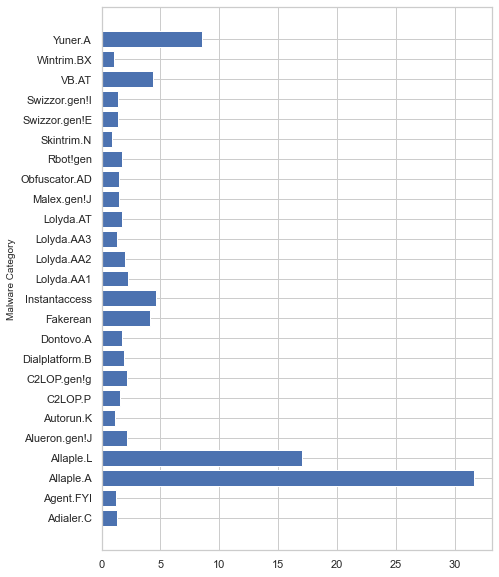

In [12]:
plt.figure(figsize=(7, 10))
plt.yticks(rotation='horizontal')
plt.ylabel('Malware Category', fontsize=10)
plt.rc('ytick', labelsize=12)
plt.barh(list(batches.class_indices.keys()),
         [x for x in ((sum(labels) / labels.shape[0]) * 100)])

In [30]:
pd.DataFrame({
    'Malware-Family':
    list(batches.class_indices.keys()),
    'Malware-Group': [
        'Dialer', 'Backdoor', 'Worm', 'Worm', 'Trojan', 'Worm AutoIT',
        'Trojan', 'Trojan', 'Dialer', 'Trojan Downloader', 'Rouge', 'Dialer',
        'PWS', 'PWS', 'PWS', 'PWS', 'Trojan', 'Trojan Downloader', 'Backdoor',
        'Trojan', 'Trojan Downloader', 'Trojan Downloader', 'Worm',
        'Trojan Downloader', 'Worm'
    ],
    'Malware-Indicator': [x for x in range(25)],
    'Count':
    pd.Series(list(sum(labels))).apply(int),
    '%-count':
    [str(round(x, 2))[:4] for x in ((sum(labels) / labels.shape[0]) * 100)]
}).style.hide_index()

Malware-Family,Malware-Group,Malware-Indicator,Count,%-count
Adialer.C,Dialer,0,122,1.31
Agent.FYI,Backdoor,1,116,1.24
Allaple.A,Worm,2,2949,31.5
Allaple.L,Worm,3,1591,17.0
Alueron.gen!J,Trojan,4,198,2.12
Autorun.K,Worm AutoIT,5,106,1.14
C2LOP.P,Trojan,6,146,1.56
C2LOP.gen!g,Trojan,7,200,2.14
Dialplatform.B,Dialer,8,177,1.9
Dontovo.A,Trojan Downloader,9,162,1.73


## Split Data into Train & Test 

### Scale Images 

In [11]:
scaled_imgs = imgs/255

### Split Data 

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_imgs,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=9,
                                                    shuffle=True)

In [29]:
sum(Y_train)

array([ 102.,   92., 2368., 1291.,  158.,   83.,  109.,  160.,  135.,
        127.,  317.,  332.,  169.,  143.,  102.,  131.,  108.,  117.,
        122.,   69.,  105.,  105.,  323.,   76.,  627.], dtype=float32)

In [30]:
sum(Y_test)

array([ 20.,  24., 581., 300.,  40.,  23.,  37.,  40.,  42.,  35.,  64.,
        99.,  44.,  41.,  21.,  28.,  28.,  25.,  36.,  11.,  23.,  27.,
        85.,  21., 173.], dtype=float32)

# Visualize Train

In [34]:
def plots(ims, figsize=(20, 30), rows=10, cols=10, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
    f = plt.figure(figsize=figsize)
    for i in range(0, 50):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(
                titles[i])],
                         fontsize=16)
        plt.imshow(ims[i], cmap='gray', vmin=0, vmax=255)

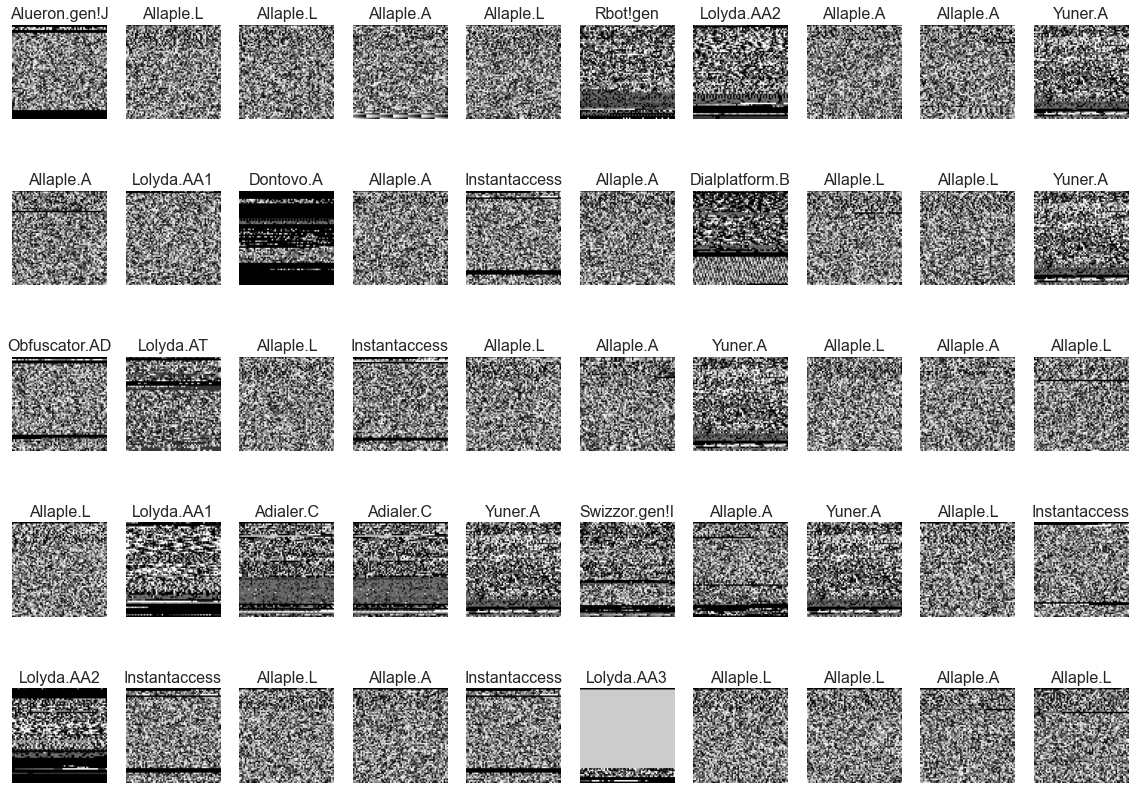

In [35]:
plots(imgs,titles=labels)

    ** This is portable executable file represented as black-white Image with different sections described as follows

![alt text](pe_file_as_image.png "pe")

# Experimentation 

    ** Idea is to extract important variant features using CNN architecture and convert it into image

## Hyper Space Definition

In [13]:
image_size = 64
patch_size = 6
num_patches = (image_size // patch_size)**2
projection_dim = 64
no_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

## Model Architecture

##### Class Weight

In [21]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(np.argmax(Y_train, axis=1)).tolist(), np.argmax(Y_train, axis=1))

In [22]:
class_weights

array([2.99529412, 3.32086957, 0.12902027, 0.23665376, 1.93367089,
       1.22208   , 2.80293578, 1.9095    , 2.26311111, 2.40566929,
       0.96378549, 0.92024096, 1.80781065, 2.1365035 , 2.99529412,
       2.33221374, 2.82888889, 2.61128205, 2.5042623 , 4.42782609,
       2.90971429, 2.90971429, 0.94588235, 4.02      , 0.48727273])

##### Data Augmentation

In [23]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.2,
                                                     width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train)

In [24]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [25]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [26]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches,
                                                   output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Experiment-101 : As-Is

In [41]:
def cnn_vit_classifier():
    inputs = layers.Input(shape=(64, 64, 1))
    augmented = data_augmentation(inputs)
    augmented = layers.Conv2D(64, 9, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.Conv2D(64, 7, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.Conv2D(num_patches,
                              patch_size,
                              strides=1,
                              padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=no_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation,
                   hidden_units=mlp_head_units,
                   dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(25, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [42]:
model = cnn_vit_classifier()

In [44]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,
                                                momentum=0.008,
                                                nesterov=True),
              loss='categorical_crossentropy',
              metrics=[keras.metrics.categorical_accuracy])

In [108]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, Y_test),
    use_multiprocessing=True)

Epoch 1/50
234/234 [==============================] - 25s 91ms/step - loss: 2.7088 - categorical_accuracy: 0.3137 - val_loss: 3.1820 - val_categorical_accuracy: 0.0782
Epoch 2/50
234/234 [==============================] - 21s 89ms/step - loss: 1.9556 - categorical_accuracy: 0.4359 - val_loss: 2.0684 - val_categorical_accuracy: 0.4615
Epoch 3/50
234/234 [==============================] - 21s 90ms/step - loss: 1.6610 - categorical_accuracy: 0.4907 - val_loss: 1.8097 - val_categorical_accuracy: 0.5391
Epoch 4/50
234/234 [==============================] - 21s 90ms/step - loss: 1.4523 - categorical_accuracy: 0.5238 - val_loss: 1.7666 - val_categorical_accuracy: 0.5600
Epoch 5/50
234/234 [==============================] - 21s 90ms/step - loss: 1.3258 - categorical_accuracy: 0.5532 - val_loss: 1.3403 - val_categorical_accuracy: 0.6665
Epoch 6/50
234/234 [==============================] - 21s 90ms/step - loss: 1.2056 - categorical_accuracy: 0.5894 - val_loss: 1.3641 - val_categorical_accuracy:

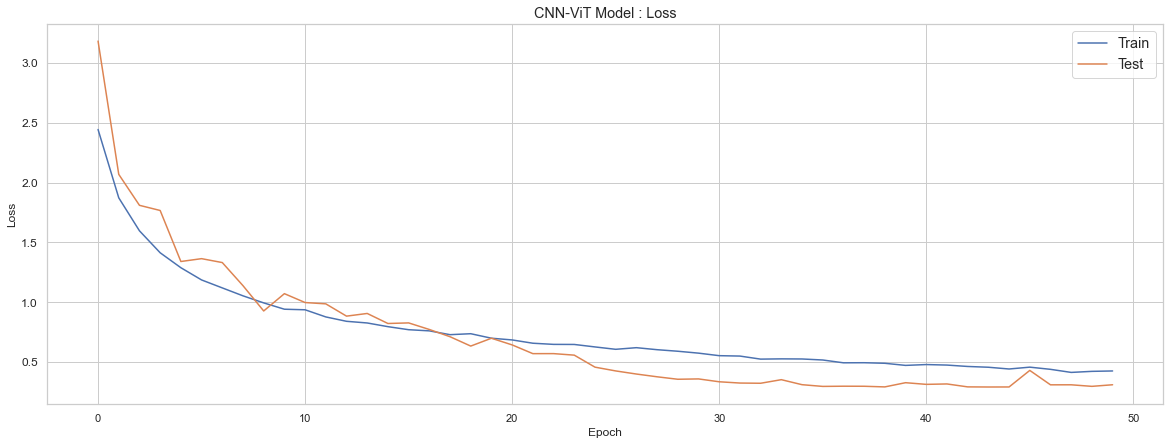

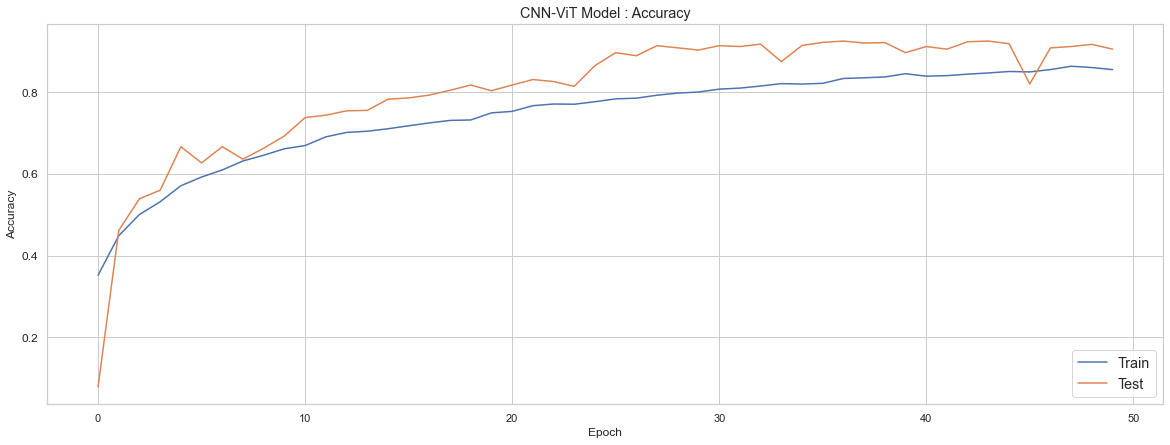

In [109]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-ViT Model : Loss', fontsize='x-large')
plt.ylabel('Loss', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], loc='upper right', fontsize='x-large')
plt.rc('ytick', labelsize=12)
plt.show()
plt.figure(figsize=(20, 7))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('CNN-ViT Model : Accuracy', fontsize='x-large')
plt.ylabel('Accuracy', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], fontsize='x-large', loc='lower right')
plt.show()

In [110]:
y_train_pred = model.predict(X_train, workers=-1, use_multiprocessing=True)
y_test_pred = model.predict(X_test, workers=-1, use_multiprocessing=True)

### Train 

In [111]:
np.round(
    evaluate_model(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(y_train_pred, axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,90.2155,90.2155,0.41,9.78,99.22,90.2155
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,85.94,95.41,1.92,14.06,94.23,90.42
3,98.37,81.1,4.79,1.63,95.76,88.9
4,100,88.76,0.27,0.00,99.73,94.05
5,0,-99,0.00,100.00,98.89,0
6,41.28,84.91,0.11,58.72,99.04,55.56
7,81.25,82.8,0.37,18.75,99.24,82.02
8,98.52,100,0.00,1.48,99.97,99.25


In [112]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_train, axis=1).tolist(),
    np.argmax(y_train_pred, axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        92
           2       0.95      0.86      0.90      2368
           3       0.81      0.98      0.89      1291
           4       0.89      1.00      0.94       158
           5       0.00      0.00      0.00        83
           6       0.85      0.41      0.56       109
           7       0.83      0.81      0.82       160
           8       1.00      0.99      0.99       135
           9       1.00      1.00      1.00       127
          10       0.99      0.99      0.99       317
          11       0.97      1.00      0.99       332
          12       0.93      0.93      0.93       169
          13       0.90      0.96      0.93       143
          14       1.00      1.00      1.00       102
          15       0.96      0.98      0.97       131
          16       0.62      0.39      0.48       108
          17       1.00    

### Test

In [113]:
np.round(
    evaluate_model(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(y_test_pred, axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,90.5246,90.5246,0.39,9.48,99.24,90.5246
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,87.09,96.75,1.32,12.91,95.07,91.67
3,99.67,80.38,4.66,0.33,96.04,88.99
4,100,90.91,0.22,0.00,99.79,95.24
5,0,-99,0.00,100.00,98.77,0
6,43.24,88.89,0.11,56.76,98.77,58.18
7,75,69.77,0.71,25.00,98.77,72.29
8,100,100,0.00,0.00,100.00,100


In [114]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_test, axis=1).tolist(),
    np.argmax(y_test_pred, axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        24
           2       0.97      0.87      0.92       581
           3       0.80      1.00      0.89       300
           4       0.91      1.00      0.95        40
           5       0.00      0.00      0.00        23
           6       0.89      0.43      0.58        37
           7       0.70      0.75      0.72        40
           8       1.00      1.00      1.00        42
           9       1.00      1.00      1.00        35
          10       0.98      0.95      0.97        64
          11       0.96      1.00      0.98        99
          12       0.92      1.00      0.96        44
          13       0.95      0.90      0.92        41
          14       1.00      1.00      1.00        21
          15       0.97      1.00      0.98        28
          16       0.81      0.46      0.59        28
          17       1.00    

In [81]:
sklearn.metrics.accuracy_score(
    np.argmax(Y_test, axis=1).tolist(),
    np.argmax(y_test_pred, axis=1).tolist())

0.8137044967880086

## Experiment-102 : SMOTE

    ** SMOTE: Synthetic Minority Over-sampling Technique

In [14]:
from imblearn.over_sampling import SMOTE

In [18]:
over_sample = SMOTE(sampling_strategy={5: 250},
                    random_state=9,
                    k_neighbors=5,
                    n_jobs=-1)
X_train, Y_train = over_sample.fit_resample(
    X_train.reshape(X_train.shape[0], 64 * 64 * 1), Y_train)
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)

In [19]:
sum(Y_train)

array([ 102,   92, 2368, 1291,  158,  250,  109,  160,  135,  127,  317,
        332,  169,  143,  102,  131,  108,  117,  122,   69,  105,  105,
        323,   76,  627])

In [20]:
X_train.shape

(7638, 64, 64, 1)

In [32]:
def cnn_vit_classifier():
    inputs = layers.Input(shape=(64, 64, 1))
    augmented = data_augmentation(inputs)
    augmented = layers.Conv2D(32, 3, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(1, 1),
                                 padding='same')(augmented)
    augmented = layers.Conv2D(64, 5, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(1, 1),
                                 padding='same')(augmented)
    augmented = layers.Conv2D(64, 7, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(1, 1),
                                 padding='same')(augmented)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=no_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation,
                   hidden_units=mlp_head_units,
                   dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(25, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [33]:
model = cnn_vit_classifier()

In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 64, 64, 1)    3           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   320         data_augmentation[1][0]          
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 64, 64, 32)   128         conv2d_3[0][0]                   
____________________________________________________________________________________________

In [35]:
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.0003,
                                             weight_decay=0.00001),
              loss='categorical_crossentropy',
              metrics=[keras.metrics.categorical_accuracy])

In [36]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=16,
    epochs=100,
    validation_data=(X_test, Y_test),
    class_weight={
        k: v
        for (k, v) in zip(
            np.unique(np.argmax(Y_train, axis=1)).tolist(), class_weights)
    },
    callbacks=tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=50,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    ),
    use_multiprocessing=True)

Epoch 1/100
478/478 [==============================] - 52s 91ms/step - loss: 3.6454 - categorical_accuracy: 0.2213 - val_loss: 1.5466 - val_categorical_accuracy: 0.4454
Epoch 2/100
478/478 [==============================] - 43s 91ms/step - loss: 1.2220 - categorical_accuracy: 0.5040 - val_loss: 0.8278 - val_categorical_accuracy: 0.5905
Epoch 3/100
478/478 [==============================] - 44s 92ms/step - loss: 0.8794 - categorical_accuracy: 0.5739 - val_loss: 0.7415 - val_categorical_accuracy: 0.5712
Epoch 4/100
478/478 [==============================] - 44s 93ms/step - loss: 0.7494 - categorical_accuracy: 0.6049 - val_loss: 1.7006 - val_categorical_accuracy: 0.4443
Epoch 5/100
478/478 [==============================] - 44s 93ms/step - loss: 0.6546 - categorical_accuracy: 0.6109 - val_loss: 0.9929 - val_categorical_accuracy: 0.6606
Epoch 6/100
478/478 [==============================] - 44s 92ms/step - loss: 0.6263 - categorical_accuracy: 0.6332 - val_loss: 6.1071 - val_categorical_acc

478/478 [==============================] - 45s 93ms/step - loss: 0.2197 - categorical_accuracy: 0.8459 - val_loss: 0.4384 - val_categorical_accuracy: 0.8383
Epoch 50/100
478/478 [==============================] - 45s 93ms/step - loss: 0.1881 - categorical_accuracy: 0.8458 - val_loss: 0.2993 - val_categorical_accuracy: 0.8249
Epoch 51/100
478/478 [==============================] - 45s 93ms/step - loss: 0.2199 - categorical_accuracy: 0.8587 - val_loss: 0.3648 - val_categorical_accuracy: 0.8983
Epoch 52/100
478/478 [==============================] - 45s 93ms/step - loss: 0.2143 - categorical_accuracy: 0.8526 - val_loss: 0.2210 - val_categorical_accuracy: 0.8651
Epoch 53/100
478/478 [==============================] - 45s 93ms/step - loss: 0.1731 - categorical_accuracy: 0.8627 - val_loss: 0.6159 - val_categorical_accuracy: 0.7805
Epoch 54/100
478/478 [==============================] - 45s 95ms/step - loss: 0.1891 - categorical_accuracy: 0.8582 - val_loss: 0.2485 - val_categorical_accuracy: 

478/478 [==============================] - 46s 96ms/step - loss: 0.1517 - categorical_accuracy: 0.8999 - val_loss: 0.1572 - val_categorical_accuracy: 0.9577
Epoch 98/100
478/478 [==============================] - 46s 96ms/step - loss: 0.1078 - categorical_accuracy: 0.9020 - val_loss: 0.2063 - val_categorical_accuracy: 0.9443
Epoch 99/100
478/478 [==============================] - 45s 95ms/step - loss: 0.1129 - categorical_accuracy: 0.9194 - val_loss: 0.1641 - val_categorical_accuracy: 0.9695
Epoch 100/100
478/478 [==============================] - 45s 95ms/step - loss: 0.1151 - categorical_accuracy: 0.9226 - val_loss: 0.2912 - val_categorical_accuracy: 0.9138


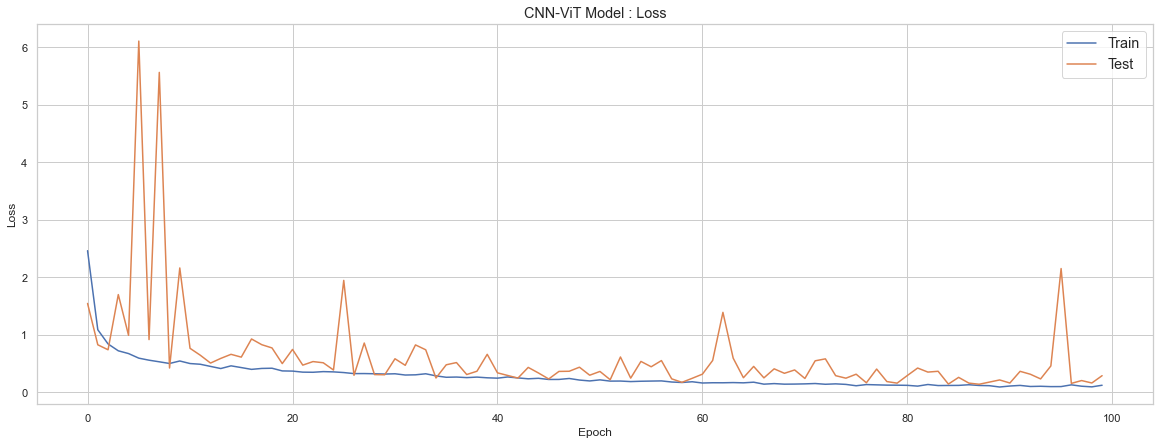

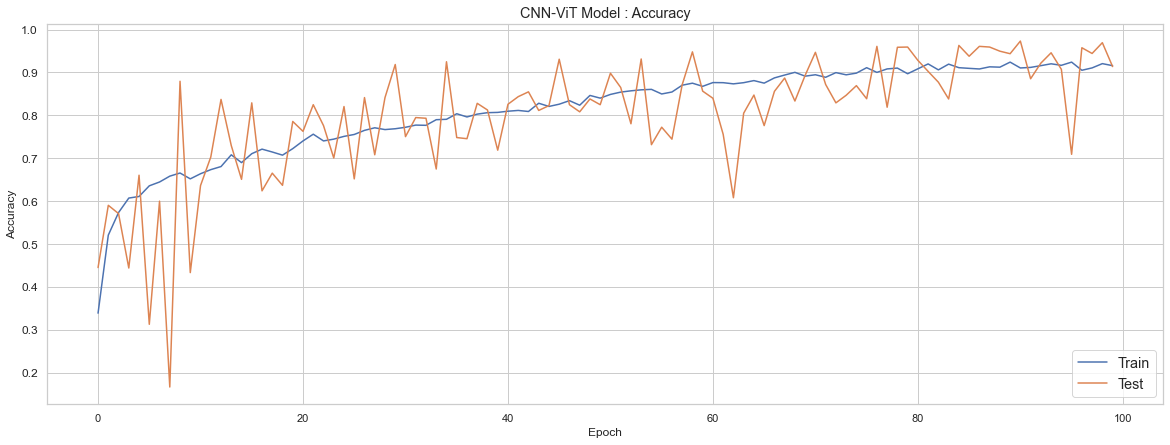

In [37]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-ViT Model : Loss', fontsize='x-large')
plt.ylabel('Loss', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], loc='upper right', fontsize='x-large')
plt.rc('ytick', labelsize=12)
plt.show()
plt.figure(figsize=(20, 7))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('CNN-ViT Model : Accuracy', fontsize='x-large')
plt.ylabel('Accuracy', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], fontsize='x-large', loc='lower right')
plt.show()

### Train 

In [38]:
np.round(
    evaluate_model(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(model.predict(
            X_train, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,93.4669,93.4669,0.27,6.53,99.48,93.4669
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,80.87,99.95,0.02,19.13,94.06,89.4
3,99.85,90.71,2.08,0.15,98.25,95.06
4,100,94.05,0.13,0.00,99.87,96.93
5,100,100,0.00,0.00,100.00,100
6,97.25,100,0.00,2.75,99.96,98.6
7,94.37,98.05,0.04,5.63,99.84,96.18
8,100,100,0.00,0.00,100.00,100


In [42]:
print(
    sklearn.metrics.classification_report(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(model.predict(X_train, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        92
           2       1.00      0.81      0.89      2368
           3       0.91      1.00      0.95      1291
           4       0.94      1.00      0.97       158
           5       1.00      1.00      1.00       250
           6       1.00      0.97      0.99       109
           7       0.98      0.94      0.96       160
           8       1.00      1.00      1.00       135
           9       1.00      1.00      1.00       127
          10       1.00      1.00      1.00       317
          11       1.00      0.97      0.98       332
          12       0.99      1.00      1.00       169
          13       1.00      0.99      0.99       143
          14       1.00      1.00      1.00       102
          15       0.96      0.99      0.97       131
          16       0.69      1.00      0.82       108
          17       1.00    

### Test

In [41]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_test, axis=1).tolist(),
        np.argmax(model.predict(
            X_test, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        24
           2       1.00      0.82      0.90       581
           3       0.91      1.00      0.96       300
           4       0.83      1.00      0.91        40
           5       1.00      1.00      1.00        23
           6       0.77      0.65      0.71        37
           7       0.80      0.80      0.80        40
           8       1.00      1.00      1.00        42
           9       1.00      1.00      1.00        35
          10       1.00      0.95      0.98        64
          11       1.00      0.97      0.98        99
          12       0.96      1.00      0.98        44
          13       1.00      0.98      0.99        41
          14       1.00      1.00      1.00        21
          15       0.93      1.00      0.97        28
          16       0.66      0.96      0.78        28
          17       1.00    

In [40]:
np.round(
    evaluate_model(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(model.predict(
            X_test, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,91.3812,91.3812,0.36,8.62,99.31,91.3812
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,81.76,99.58,0.16,18.24,94.22,89.79
3,100,91.46,1.79,0.00,98.50,95.54
4,100,83.33,0.44,0.00,99.57,90.91
5,100,100,0.00,0.00,100.00,100
6,64.86,77.42,0.38,35.14,98.93,70.59
7,80,80,0.44,20.00,99.14,80
8,100,100,0.00,0.00,100.00,100


### Feature Map Visualize 

In [56]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)
del i

2 conv2d (None, 64, 64, 256)
5 conv2d_1 (None, 64, 64, 256)
8 conv2d_2 (None, 64, 64, 144)


In [59]:
model.layers[8].output_shape

(None, 64, 64, 144)

In [99]:
model.input_shape

(None, 64, 64, 1)

In [60]:
model_feature_map = tf.keras.models.Model(inputs=model.inputs , outputs=model.layers[8].output)

In [97]:
features = model_feature_map.predict(X_train[np.random.choice(
    range(X_train.shape[0]))],batch_size=None)

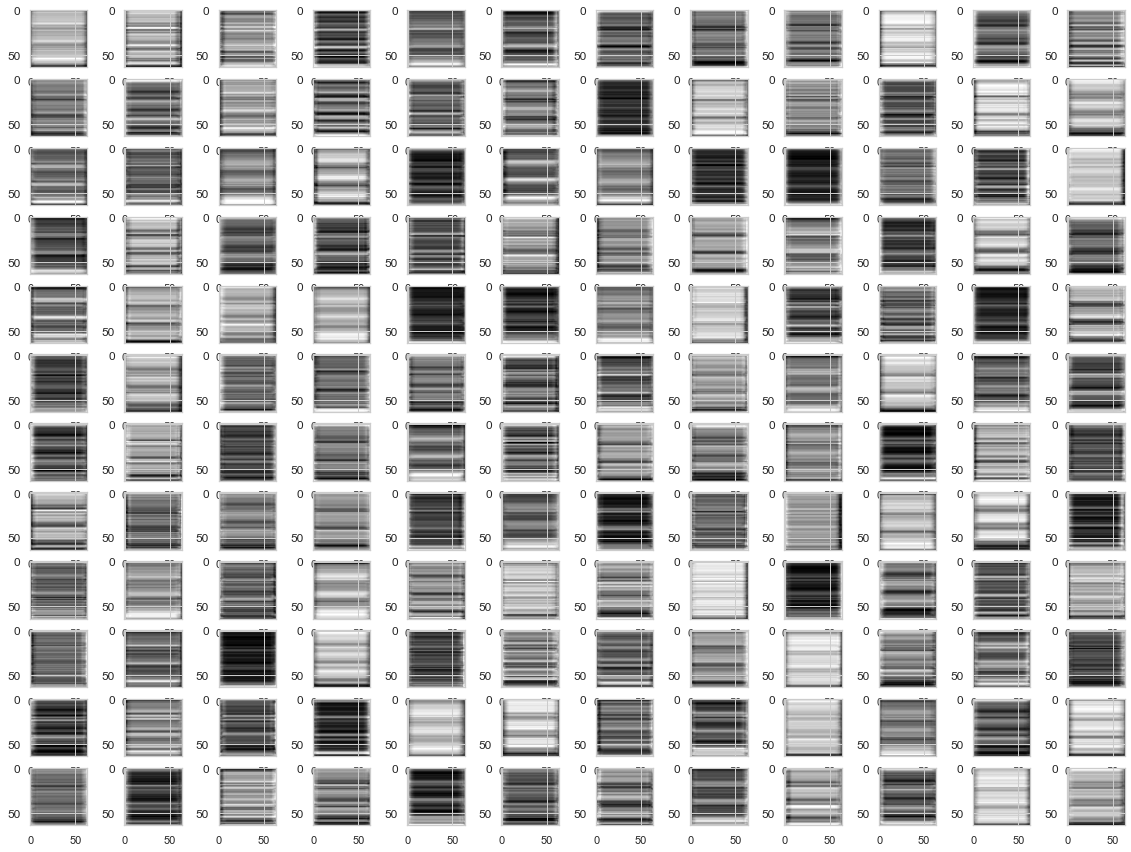

In [103]:
fig = pyplot.figure(figsize=(20, 15))
for i in range(1, features.shape[3] + 1):

    pyplot.subplot(12, 12, i)
    pyplot.imshow(features[0, :, :, i - 1], cmap='gray')

pyplot.show()
del i, fig

In [98]:
features.shape

(64, 64, 64, 144)

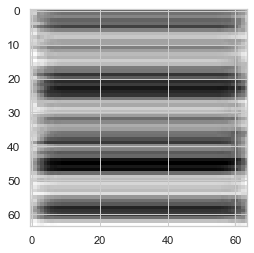

In [88]:
pyplot.imshow(features[4, :, :, 3], cmap='gray')

In [76]:
X_train[np.random.choice(
    range(X_train.shape[0]))].shape

(64, 64, 1)

In [89]:
model.input_shape

(None, 64, 64, 1)

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [126]:
tf.reshape(tf.image.extract_patches(
            images=features,
            sizes=[1, 5, 5, 1],
            strides=[1, 5, 5, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        ),[64,-1,3600]).shape

TensorShape([64, 144, 3600])

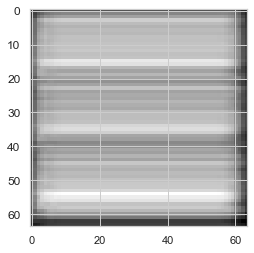

In [122]:
plt.imshow(features[0,:,:,0],cmap='gray')

In [109]:
features[np.random.choice(range(features.shape[0]))].shape

(64, 64, 144)

In [128]:
tf.image.resize(tf.convert_to_tensor(
    [X_train[np.random.choice(range(X_train.shape[0]))].astype("uint8")]),
                size=(image_size, image_size)).shape

TensorShape([1, 64, 64, 1])

(1, 144, 25)
Image size: 64 X 64
Patch size: 5 X 5
Patches per image: 144
Elements per patch: 25


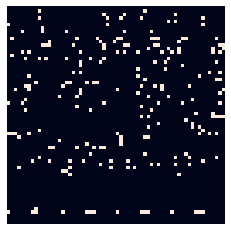

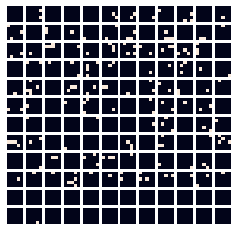

In [124]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(tf.convert_to_tensor([image]),
                                size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(patches.shape)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
del image, resized_image, patches, n, i, patch

In [106]:
features[np.random.choice(range(features.shape[0]))].shape

(64, 64, 144)

## Experiment-103

In [46]:
def cnn_vit_classifier():
    inputs = layers.Input(shape=(64, 64, 1))
    augmented = data_augmentation(inputs)
    augmented = layers.Conv2D(32, 3, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(1, 1),
                                 padding='same')(augmented)
    augmented = layers.Conv2D(64, 3, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(1, 1),
                                 padding='same')(augmented)
    augmented = layers.Conv2D(64, 3, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(1, 1),
                                 padding='same')(augmented)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=no_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation,
                   hidden_units=mlp_head_units,
                   dropout_rate=0.6)
    # Classify outputs.
    logits = layers.Dense(25, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [47]:
model = cnn_vit_classifier()

In [48]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 64, 64, 1)    3           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         data_augmentation[2][0]          
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 64, 64, 32)   128         conv2d_6[0][0]                   
____________________________________________________________________________________________

In [49]:
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.0003,
                                             weight_decay=0.00001),
              loss='categorical_crossentropy',
              metrics=[keras.metrics.categorical_accuracy])

In [100]:
history = model.fit(x=X_train,
                    y=Y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    callbacks=tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=5,
                        verbose=1,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    ),
                    use_multiprocessing=True)

Epoch 1/10
239/239 [==============================] - 24s 99ms/step - loss: 0.0558 - categorical_accuracy: 0.9777 - val_loss: 0.1550 - val_categorical_accuracy: 0.9700
Epoch 2/10
239/239 [==============================] - 24s 100ms/step - loss: 0.0513 - categorical_accuracy: 0.9809 - val_loss: 0.1459 - val_categorical_accuracy: 0.9695
Epoch 3/10
239/239 [==============================] - 23s 97ms/step - loss: 0.0445 - categorical_accuracy: 0.9827 - val_loss: 0.0994 - val_categorical_accuracy: 0.9797
Epoch 4/10
239/239 [==============================] - 23s 97ms/step - loss: 0.0542 - categorical_accuracy: 0.9805 - val_loss: 0.1330 - val_categorical_accuracy: 0.9786
Epoch 5/10
239/239 [==============================] - 23s 96ms/step - loss: 0.0535 - categorical_accuracy: 0.9764 - val_loss: 0.1298 - val_categorical_accuracy: 0.9786
Epoch 6/10
239/239 [==============================] - 23s 97ms/step - loss: 0.0593 - categorical_accuracy: 0.9760 - val_loss: 0.1506 - val_categorical_accuracy

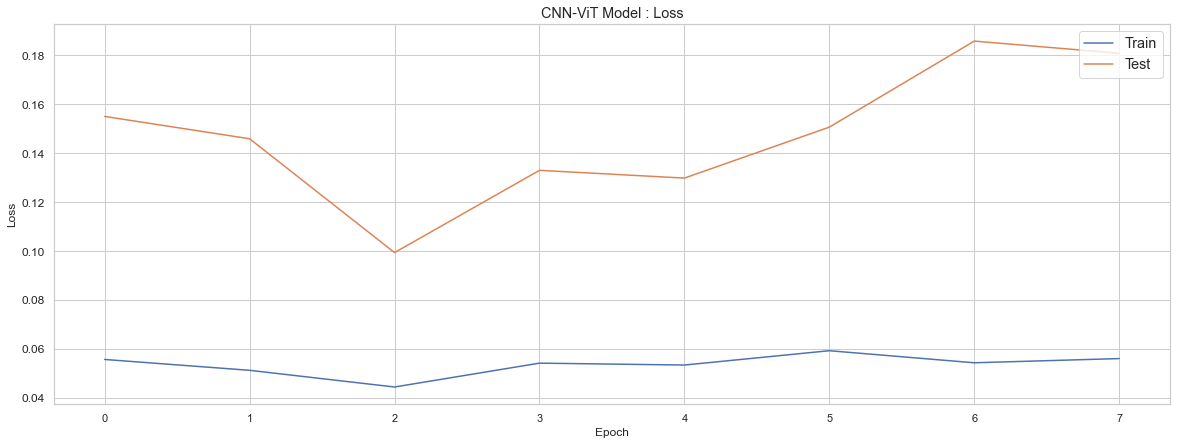

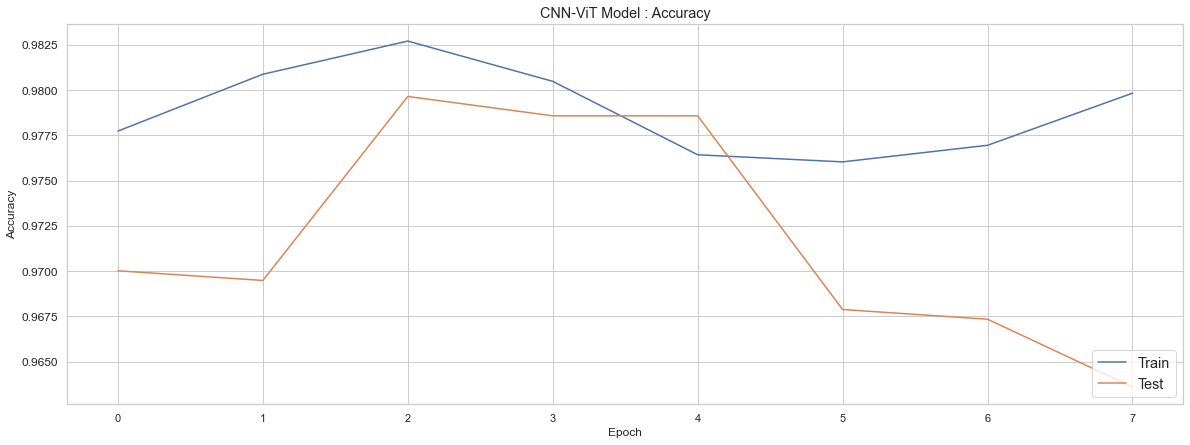

In [101]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-ViT Model : Loss', fontsize='x-large')
plt.ylabel('Loss', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], loc='upper right', fontsize='x-large')
plt.rc('ytick', labelsize=12)
plt.show()
plt.figure(figsize=(20, 7))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('CNN-ViT Model : Accuracy', fontsize='x-large')
plt.ylabel('Accuracy', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], fontsize='x-large', loc='lower right')
plt.show()

### Train 

In [82]:
np.round(
    evaluate_model(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(model.predict(
            X_train, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,99.9214,99.9214,0.00,0.08,99.99,99.9214
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,100,99.83,0.08,0.00,99.95,99.92
3,99.69,100,0.00,0.31,99.95,99.84
4,100,100,0.00,0.00,100.00,100
5,100,100,0.00,0.00,100.00,100
6,100,100,0.00,0.00,100.00,100
7,100,100,0.00,0.00,100.00,100
8,100,100,0.00,0.00,100.00,100


In [83]:
print(
    sklearn.metrics.classification_report(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(model.predict(X_train, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        92
           2       1.00      1.00      1.00      2368
           3       1.00      1.00      1.00      1291
           4       1.00      1.00      1.00       158
           5       1.00      1.00      1.00       250
           6       1.00      1.00      1.00       109
           7       1.00      1.00      1.00       160
           8       1.00      1.00      1.00       135
           9       1.00      1.00      1.00       127
          10       1.00      1.00      1.00       317
          11       1.00      1.00      1.00       332
          12       1.00      1.00      1.00       169
          13       1.00      1.00      1.00       143
          14       1.00      1.00      1.00       102
          15       1.00      1.00      1.00       131
          16       1.00      1.00      1.00       108
          17       1.00    

### Test

In [84]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_test, axis=1).tolist(),
        np.argmax(model.predict(
            X_test, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        24
           2       0.99      1.00      0.99       581
           3       1.00      0.99      0.99       300
           4       0.95      1.00      0.98        40
           5       1.00      1.00      1.00        23
           6       0.85      0.89      0.87        37
           7       0.84      0.93      0.88        40
           8       1.00      1.00      1.00        42
           9       1.00      1.00      1.00        35
          10       1.00      0.98      0.99        64
          11       1.00      1.00      1.00        99
          12       1.00      1.00      1.00        44
          13       1.00      0.98      0.99        41
          14       1.00      1.00      1.00        21
          15       1.00      0.96      0.98        28
          16       1.00      0.93      0.96        28
          17       1.00    

In [85]:
np.round(
    evaluate_model(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(model.predict(
            X_test, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,98.1263,98.1263,0.08,1.87,99.85,98.1263
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,99.83,98.98,0.47,0.17,99.63,99.4
3,99,100,0.00,1.00,99.84,99.5
4,100,95.24,0.11,0.00,99.89,97.56
5,100,100,0.00,0.00,100.00,100
6,89.19,84.62,0.33,10.81,99.46,86.84
7,92.5,84.09,0.38,7.50,99.46,88.1
8,100,100,0.00,0.00,100.00,100


# Model Evaluate : Final Model

In [110]:
y_train_pred = model.predict(X_train, workers=-1, use_multiprocessing=True)
y_test_pred = model.predict(X_test, workers=-1, use_multiprocessing=True)

## Train 

In [111]:
np.round(
    evaluate_model(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(y_train_pred, axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,90.2155,90.2155,0.41,9.78,99.22,90.2155
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,85.94,95.41,1.92,14.06,94.23,90.42
3,98.37,81.1,4.79,1.63,95.76,88.9
4,100,88.76,0.27,0.00,99.73,94.05
5,0,-99,0.00,100.00,98.89,0
6,41.28,84.91,0.11,58.72,99.04,55.56
7,81.25,82.8,0.37,18.75,99.24,82.02
8,98.52,100,0.00,1.48,99.97,99.25


In [112]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_train, axis=1).tolist(),
    np.argmax(y_train_pred, axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        92
           2       0.95      0.86      0.90      2368
           3       0.81      0.98      0.89      1291
           4       0.89      1.00      0.94       158
           5       0.00      0.00      0.00        83
           6       0.85      0.41      0.56       109
           7       0.83      0.81      0.82       160
           8       1.00      0.99      0.99       135
           9       1.00      1.00      1.00       127
          10       0.99      0.99      0.99       317
          11       0.97      1.00      0.99       332
          12       0.93      0.93      0.93       169
          13       0.90      0.96      0.93       143
          14       1.00      1.00      1.00       102
          15       0.96      0.98      0.97       131
          16       0.62      0.39      0.48       108
          17       1.00    

## Test

In [113]:
np.round(
    evaluate_model(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(y_test_pred, axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,90.5246,90.5246,0.39,9.48,99.24,90.5246
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,87.09,96.75,1.32,12.91,95.07,91.67
3,99.67,80.38,4.66,0.33,96.04,88.99
4,100,90.91,0.22,0.00,99.79,95.24
5,0,-99,0.00,100.00,98.77,0
6,43.24,88.89,0.11,56.76,98.77,58.18
7,75,69.77,0.71,25.00,98.77,72.29
8,100,100,0.00,0.00,100.00,100


In [114]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_test, axis=1).tolist(),
    np.argmax(y_test_pred, axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        24
           2       0.97      0.87      0.92       581
           3       0.80      1.00      0.89       300
           4       0.91      1.00      0.95        40
           5       0.00      0.00      0.00        23
           6       0.89      0.43      0.58        37
           7       0.70      0.75      0.72        40
           8       1.00      1.00      1.00        42
           9       1.00      1.00      1.00        35
          10       0.98      0.95      0.97        64
          11       0.96      1.00      0.98        99
          12       0.92      1.00      0.96        44
          13       0.95      0.90      0.92        41
          14       1.00      1.00      1.00        21
          15       0.97      1.00      0.98        28
          16       0.81      0.46      0.59        28
          17       1.00    

In [81]:
sklearn.metrics.accuracy_score(
    np.argmax(Y_test, axis=1).tolist(),
    np.argmax(y_test_pred, axis=1).tolist())

0.8137044967880086

In [82]:
sum(Y_test)

array([ 20.,  24., 581., 300.,  40.,  23.,  37.,  40.,  42.,  35.,  64.,
        99.,  44.,  41.,  21.,  28.,  28.,  25.,  36.,  11.,  23.,  27.,
        85.,  21., 173.], dtype=float32)

# Model Dump-Yard

In [86]:
model.save(
    "D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_104_CNN_with_ViT_Acc_98.sav",
    overwrite=True,
    include_optimizer=True)

INFO:tensorflow:Assets written to: D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_104_CNN_with_ViT_Acc_98.sav\assets


INFO:tensorflow:Assets written to: D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_104_CNN_with_ViT_Acc_98.sav\assets


In [87]:
loaded_model = tf.keras.models.load_model(
    "D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_104_CNN_with_ViT_Acc_98.sav",
    custom_objects={
        'mlp': mlp,
        'Patches': Patches,
        'PatchEncoder': PatchEncoder
    },
    compile=True,
    options=None)

In [88]:
np.round(
    evaluate_model(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(loaded_model.predict(
            X_test, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,97.8051,97.8051,0.09,2.19,99.82,97.8051
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,99.66,99.48,0.23,0.34,99.73,99.57
3,100,99.34,0.13,0.00,99.89,99.67
4,100,95.24,0.11,0.00,99.89,97.56
5,100,100,0.00,0.00,100.00,100
6,89.19,75,0.60,10.81,99.20,81.48
7,82.5,89.19,0.22,17.50,99.41,85.71
8,100,97.67,0.05,0.00,99.95,98.82


In [65]:
 import joblib

In [89]:
joblib.dump(
    history.history,
    "D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_104_CNN_with_ViT_Acc_98_History.pkl"
)

['D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_104_CNN_with_ViT_Acc_98_History.pkl']

In [98]:
np.round(
    evaluate_model(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(tf.keras.models.load_model(
            "D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_103_CNN_with_ViT_Acc_97.sav",
            custom_objects={
                'mlp': mlp,
                'Patches': Patches,
                'PatchEncoder': PatchEncoder
            },
            compile=True,
            options=None).predict(X_train, workers=-1,
                                  use_multiprocessing=True),
            axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,99.3454,99.3454,0.03,0.65,99.95,99.3454
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,99.66,99.92,0.04,0.34,99.87,99.79
3,99.92,99.92,0.02,0.08,99.97,99.92
4,100,95.76,0.09,0.00,99.91,97.83
5,100,100,0.00,0.00,100.00,100
6,96.33,100,0.00,3.67,99.95,98.13
7,98.75,98.75,0.03,1.25,99.95,98.75
8,100,100,0.00,0.00,100.00,100


In [90]:
np.round(
    evaluate_model(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(tf.keras.models.load_model(
            "D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_103_CNN_with_ViT_Acc_97.sav",
            custom_objects={
                'mlp': mlp,
                'Patches': Patches,
                'PatchEncoder': PatchEncoder
            },
            compile=True,
            options=None).predict(X_test, workers=-1,
                                  use_multiprocessing=True),
            axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,97.3233,97.3233,0.11,2.68,99.79,97.3233
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,99.14,99.14,0.39,0.86,99.46,99.14
3,99.67,99.34,0.13,0.33,99.84,99.5
4,100,81.63,0.49,0.00,99.52,89.89
5,100,100,0.00,0.00,100.00,100
6,81.08,81.08,0.38,18.92,99.25,81.08
7,95,88.37,0.27,5.00,99.63,91.57
8,100,97.67,0.05,0.00,99.95,98.82


In [104]:
history_97 = joblib.load("D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_103_CNN_with_ViT_Acc_97_History.pkl")

In [105]:
history_97

{'loss': [0.08401349931955338,
  0.08314817398786545,
  0.07480202615261078,
  0.08416391164064407,
  0.07200945168733597,
  0.08377271145582199,
  0.07424613833427429,
  0.08304645866155624,
  0.09429733455181122,
  0.07487627118825912,
  0.08190746605396271,
  0.07540558278560638,
  0.07298226654529572,
  0.07616396993398666,
  0.07746317982673645,
  0.07243817299604416,
  0.08165079355239868,
  0.07274964451789856,
  0.08124586194753647,
  0.08446577936410904,
  0.07793576270341873,
  0.06634865701198578,
  0.08791784942150116,
  0.08139175176620483,
  0.07768121361732483,
  0.07128043472766876,
  0.07674557715654373,
  0.06780987977981567,
  0.0664081797003746,
  0.08189225941896439,
  0.06865163892507553,
  0.0726199746131897,
  0.06569818407297134,
  0.07277432084083557,
  0.06562326848506927,
  0.06641088426113129,
  0.07879813015460968,
  0.07498198747634888,
  0.07738267630338669,
  0.0760984942317009,
  0.07071693241596222,
  0.07451272010803223,
  0.0651366263628006,
  0.067

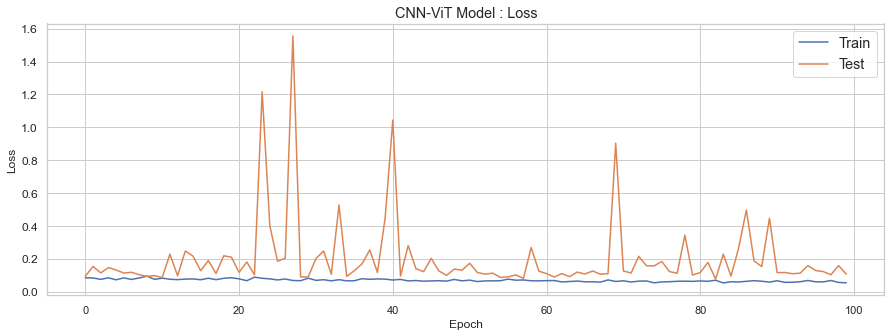

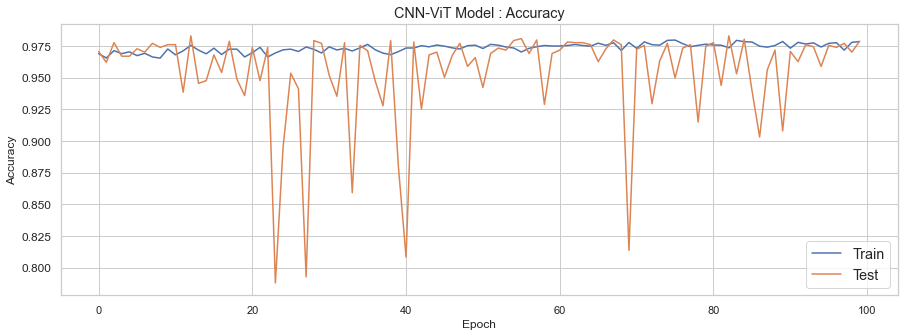

In [97]:
plt.figure(figsize=(15, 5))
plt.plot(history_97['loss'])
plt.plot(history_97['val_loss'])
plt.title('CNN-ViT Model : Loss', fontsize='x-large')
plt.ylabel('Loss', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], loc='upper right', fontsize='x-large')
plt.rc('ytick', labelsize=12)
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(history_97['categorical_accuracy'])
plt.plot(history_97['val_categorical_accuracy'])
plt.title('CNN-ViT Model : Accuracy', fontsize='x-large')
plt.ylabel('Accuracy', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], fontsize='x-large', loc='lower right')
plt.show()

In [103]:
history_98 = joblib.load("D:/Work_Space/Journel Related Work/Computer Vision Using Attension/Model_DumpYard/experiment_104_CNN_with_ViT_Acc_98_History.pkl")

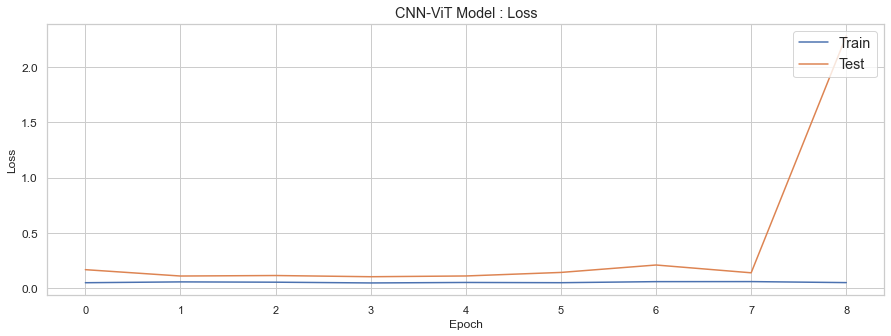

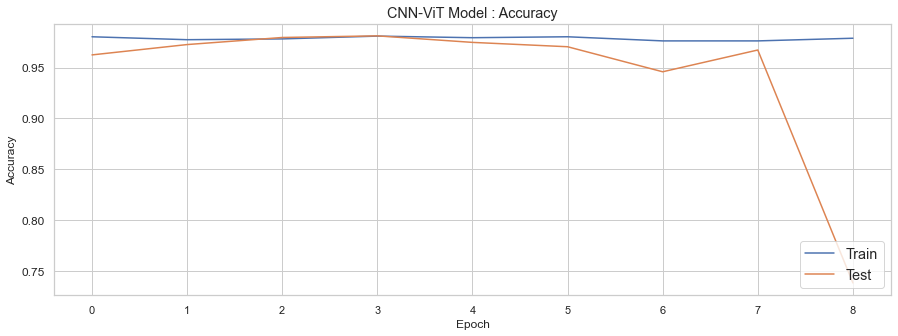

In [106]:
plt.figure(figsize=(15, 5))
plt.plot(history_98['loss'])
plt.plot(history_98['val_loss'])
plt.title('CNN-ViT Model : Loss', fontsize='x-large')
plt.ylabel('Loss', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], loc='upper right', fontsize='x-large')
plt.rc('ytick', labelsize=12)
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(history_98['categorical_accuracy'])
plt.plot(history_98['val_categorical_accuracy'])
plt.title('CNN-ViT Model : Accuracy', fontsize='x-large')
plt.ylabel('Accuracy', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], fontsize='x-large', loc='lower right')
plt.show()

In [ ]:
from sklearn import metrics

In [108]:
pd.DataFrame(
    metrics.confusion_matrix(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(loaded_model.predict(X_test,
                                       workers=-1,
                                       use_multiprocessing=True),
                  axis=1).tolist()),
    index=list(batches.class_indices.keys()),
    columns=list(batches.class_indices.keys()),
)

,Adialer.C,Agent.FYI,Allaple.A,Allaple.L,Alueron.gen!J,Autorun.K,C2LOP.P,C2LOP.gen!g,Dialplatform.B,Dontovo.A,Fakerean,Instantaccess,Lolyda.AA1,Lolyda.AA2,Lolyda.AA3,Lolyda.AT,Malex.gen!J,Obfuscator.AD,Rbot!gen,Skintrim.N,Swizzor.gen!E,Swizzor.gen!I,VB.AT,Wintrim.BX,Yuner.A
Adialer.C,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Agent.FYI,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Allaple.A,0,0,579,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Allaple.L,0,0,0,300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Alueron.gen!J,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Autorun.K,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C2LOP.P,0,0,1,0,0,0,33,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C2LOP.gen!g,0,0,0,0,0,0,4,33,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
Dialplatform.B,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dontovo.A,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_test, axis=1).tolist(),
        np.argmax(loaded_model.predict(
            X_test, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        24
           2       0.99      1.00      1.00       581
           3       0.99      1.00      1.00       300
           4       0.95      1.00      0.98        40
           5       1.00      1.00      1.00        23
           6       0.75      0.89      0.81        37
           7       0.89      0.82      0.86        40
           8       0.98      1.00      0.99        42
           9       1.00      1.00      1.00        35
          10       1.00      0.98      0.99        64
          11       1.00      1.00      1.00        99
          12       1.00      1.00      1.00        44
          13       1.00      1.00      1.00        41
          14       1.00      1.00      1.00        21
          15       1.00      0.93      0.96        28
          16       1.00      0.89      0.94        28
          17       1.00    